# Simulation 

In [1]:
import os
import sys
sys.path.append('..')
from sfp_nsdsyn import simulation as sim
from sfp_nsdsyn import two_dimensional_model as model
from sfp_nsdsyn import utils as utils
from sfp_nsdsyn.visualization import plot_2D_model_results as vis2D
from sfp_nsdsyn.cross_validation_2d_model import plot_model_comparison_params
from gsn.perform_gsn import perform_gsn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
import json
config = json.load(open('../config.json'))
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
params = pd.read_csv('/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/results_2D/nsdsyn/summary/precision_weighted_params.csv')
params = params.query('vroinames == "V1"')
params_dict = params.to_dict(orient='records')[0]

In [3]:
# load in actual subj data
subj_list = ['subj01']

roi='V1'
all_df = pd.DataFrame({})
for subj in subj_list:
    subj_data = pd.read_csv(config['OUTPUT_DIR'] + f'dataframes/nsdsyn/model/dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFsize_tavg-False.csv')
    subj_precision = pd.read_csv(config['OUTPUT_DIR'] + f'dataframes/nsdsyn/precision/precision-v_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    subj_data['trial'] = subj_data.groupby(['sub','voxel','class_idx']).cumcount()
    subj_data = subj_data.merge(subj_precision, on=['sub','voxel'])
    subj_data['normed_betas'] = model.normalize(subj_data, 'betas', ['sub','voxel'], phase_info=True)
    all_df = pd.concat([all_df, subj_data])

all_df.head()

,trial,image_idx,run,task,stim_idx,w_r,w_a,phase,class_idx,phase_idx,...,vroinames_x,eccrois,local_sf,local_ori,hemi,sub,vroinames_y,noise_SD,sigma_v_squared,normed_betas
0,0,105,7,memory,0,0.0,-6.0,0.000000,0,0,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.149929
1,1,105,2,fixation,0,0.0,-6.0,0.000000,0,0,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.048191
2,2,106,6,fixation,1,0.0,-6.0,1.570796,0,2,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.016159
3,3,106,3,memory,1,0.0,-6.0,1.570796,0,2,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.067219
4,4,107,1,memory,2,0.0,-6.0,3.141593,0,4,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.035283


In [4]:
# blue and orange for both scaled and constant conditions
low_colors = np.array([[2,116,186],[241,130,0]])
high_colors = low_colors * 0.6
color_map = [color for pair in zip(low_colors, high_colors) for color in pair]
color_map = np.divide(color_map, 255)
design_color_map = [color_map[0], color_map[2]]

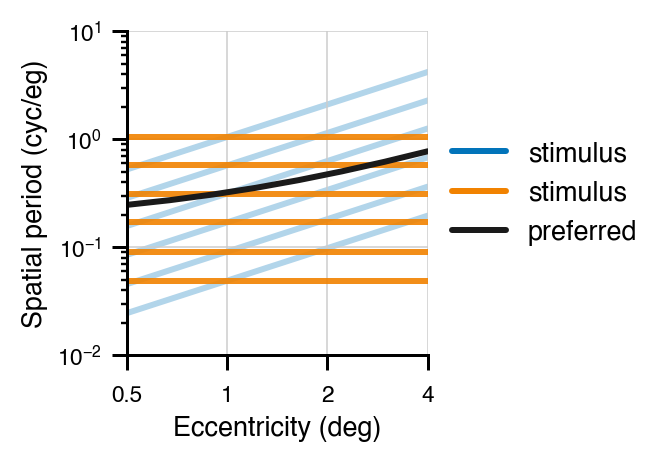

In [23]:
# Example usage
base_sfs = np.array([6, 11, 20, 37, 69, 128])  # shape (6,)
eccen = np.logspace(np.log10(0.5), np.log10(4), 8)  # shape (8,)


save_path = config['OUTPUT_DIR'] + 'figures/simulation/simulation_design.svg'
vis2D.plot_simulation_design(base_sfs, 
                             eccen, 
                             color_map=design_color_map,
                             slope=params['slope'].iloc[0], 
                             intercept=params['intercept'].iloc[0],
                             figsize=(1.8, 1.95),
                             save_path=save_path)

In [15]:
lr=0.0005
max_epoch=30000
subj='subj01'
grating_types = ['scaled', 'constant']
noise_levels = [1,3]
noise_mapping = {'1': 'matched', '3': 'high'}
pt_file_list = []
for seed in range(100):
    for grating, noise_lvl in itertools.product(grating_types, noise_levels):
        file_name = f'model-params_roi-{roi}_grating-{grating}_cov-True_noise-{noise_lvl}_lr-{lr}_eph-{max_epoch}_basesub-{subj}_slope-original_rnseed-{seed}.pt'
        pt_file_list.append(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/simulation/' + file_name)
model_df = model.load_all_models(pt_file_list, *['grating', 'noise', 'rnseed'])



model_df['noise'] = model_df['noise'].map(noise_mapping)
model_df['grating'] = model_df['grating'].map({'scaled': 'scaled', 'constant': 'uniform'})
model_df['grating-noise'] = model_df['grating'] + ' - ' + model_df['noise']


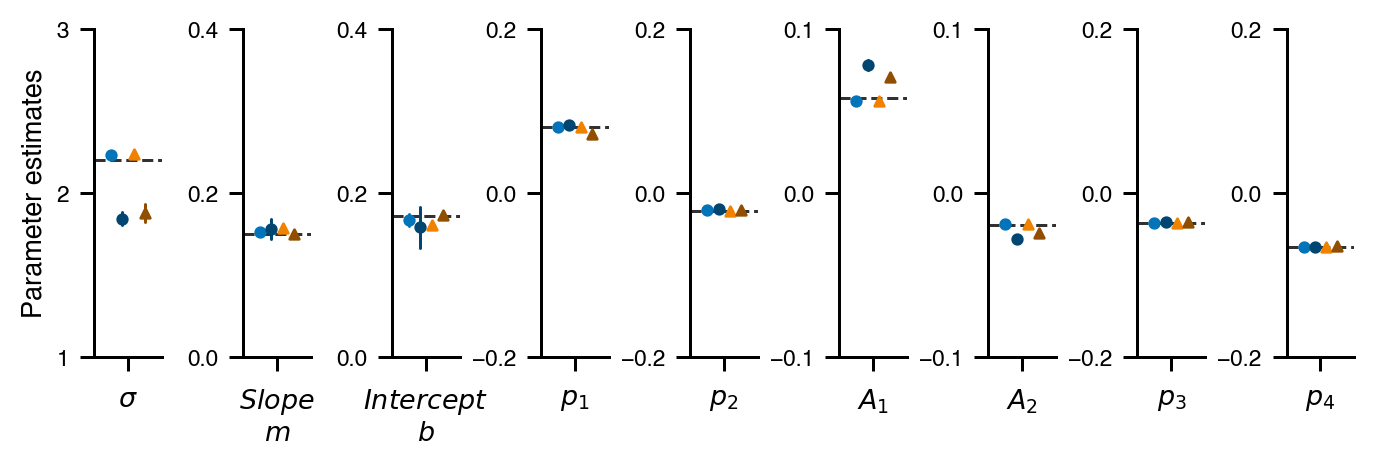

In [26]:
params_list = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'A_1','A_2','p_3', 'p_4']
params_vals = params[params_list].iloc[0].tolist()

save_path = '/Volumes/server/Projects/sfp_nsd/derivatives/figures/simulation/simulation_param_results.svg'
ylim_list = [(1, 3), (0, 0.4),(0, 0.4), (-0.2, 0.2), (-0.2, 0.2),(-0.1,0.1),(-0.1,0.1), (-0.2, 0.2), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.2,0,0.2], [-0.1,0,0.1], [-0.1,0,0.1], [-0.2,0,0.2], [-0.2,0,0.2]]
vis2D.plot_simulation_results(model_df, params_list, ground_truth=params_vals, save_path=save_path,
                              hue='grating-noise', ylim=ylim_list, yticks=yticks_list, scale=0.8,
                              figsize=(6.5, 2.3),
                              **{'palette': color_map, 'hue_order': ['scaled - matched', 'scaled - high', 
                                                                     'uniform - matched', 'uniform - high'],
                                                                     'markers':['o','o','^','^']})

In [27]:
lr=0.0005
max_epoch=30000
subj='subj01'
grating_types = ['scaled']
noise_levels = [1,3]
noise_mapping = {'1': 'matched', '3': 'high'}
pt_file_list = []
intercept=0.25
for seed in range(100):
    for grating, noise_lvl in itertools.product(grating_types, noise_levels):
        file_name = f'model-params_roi-{roi}_grating-{grating}_cov-True_noise-{noise_lvl}_lr-{lr}_eph-{max_epoch}_basesub-{subj}_slope-zero_rnseed-{seed}.pt'
        pt_file_list.append(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/simulation/' + file_name)
new_model_df = model.load_all_models(pt_file_list, *['grating', 'noise', 'rnseed'])


new_model_df['noise'] = new_model_df['noise'].map(noise_mapping)
new_model_df['grating'] = new_model_df['grating'].map({'scaled': 'scaled', 'constant': 'uniform'})
new_model_df['grating-noise'] = new_model_df['grating'] + ' - ' + new_model_df['noise']

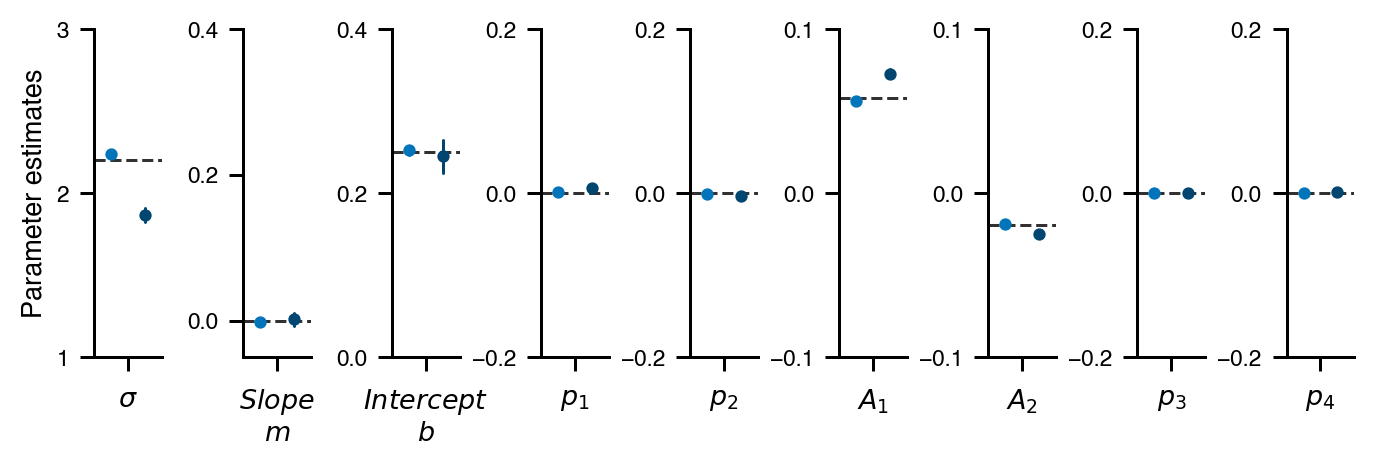

In [28]:

params_list = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'A_1','A_2','p_3', 'p_4']
params_vals = params[params_list].iloc[0].tolist()
new_params = params.copy()
new_params['slope'] = 0
new_params['p_1'] = 0
new_params['p_2'] = 0
new_params['p_3'] = 0
new_params['p_4'] = 0
new_params['intercept'] = 0.25

new_params_vals = new_params[params_list].iloc[0].tolist()

save_path = '/Volumes/server/Projects/sfp_nsd/derivatives/figures/simulation/simulation_param_results_slope-0_intercept-0.25.svg'
ylim_list = [(1, 3), (-0.05, 0.4),(0, 0.4), (-0.2, 0.2), (-0.2, 0.2),(-0.1,0.1),(-0.1,0.1), (-0.2, 0.2), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.2,0,0.2], [-0.1,0,0.1], [-0.1,0,0.1], [-0.2,0,0.2], [-0.2,0,0.2]]
vis2D.plot_simulation_results(new_model_df, params_list, ground_truth=new_params_vals, save_path=save_path,
                              hue='grating-noise', ylim=ylim_list, yticks=yticks_list, scale=0.8,
                              figsize=(6.5, 2.3),
                              **{'palette': color_map[:2], 
                                 'hue_order': ['scaled - matched', 'scaled - high'],
                                 'markers':['o','o'],})

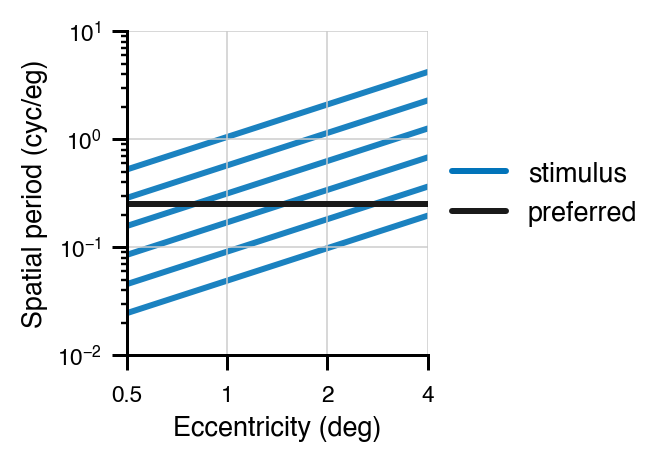

In [30]:
save_path = config['OUTPUT_DIR'] + 'figures/simulation/simulation_design_slopezero.svg'

vis2D.plot_simulation_design(base_sfs, 
                             eccen, 
                             color_map=color_map[:2],
                             slope=new_params['slope'].iloc[0], 
                             intercept=new_params['intercept'].iloc[0],
                             uniform=False,
                             figsize=(1.8, 1.95),
                             save_path=save_path)
